# Using Machine Learning to Develop New Inhibitors for the Dengue Virus Enzyme NS5 Methyltransferase

Using data from PUBCHEM BioAssay Record for AID [588689](https://pubchem.ncbi.nlm.nih.gov/bioassay/588689): 

**Primary Screen**
- Compounds with % inhibition > 28.49% are labeled *active* (mean inhibition of the compound population plus three standard deviations)
- Subsequently, compounds exhibiting autofluorescent characteristics were excluded
- Available compounds from the remaining list were screened in the confirmatory assay
- Compounds that showed activity in the primary screen, but were not available for further study are labeled as *inconclusive*
  
**Confirmatory Assay**
- Only compounds labeled as active in the primary screen were rescreened in the confirmatory assay
- Compound activity is defined as 30% or greater inhibition at any tested concentration
- IC50 was measured only for the compounds labeled as "active"
- IC50s are in micromolar units


## The General Procedure Used

1. Examine the available data
1. Remove salts
1. Remove charges
1. Standardize the molecules
1. Generate [InChi](https://en.wikipedia.org/wiki/International_Chemical_Identifier) Keys 
1. Remove duplicates based on the InChi keys
1. Use the full set to train a classifier
1. Prepare a set with actives + 10x inactives
   1. Clustering?
   1. Random?
1. Use this dataset for training a predictor
   1. Predictors (ensemble)?
1. Use the models create to reproduce the experimental setup
   1. Classify active / inactive
   1. With the "actives", predict IC50

## Modules used in this Notebook

**General Modules:**
- [Pandas](https://pandas.pydata.org/): Library for Python data analysis
- [NumPy](http://www.numpy.org/): The fundamental package for scientific computing with Python
- [MatplotLib](https://matplotlib.org/): plotting library which produces publication quality figures
- [scikit-learn](https://scikit-learn.org/): Machine Learning in Python

**Chemistry specific:**
- [RDkit](https://www.rdkit.org/): An Open Source library for cheminformatics and machine learning
- [MolVS](https://github.com/mcs07/MolVS): Molecular Validation and Standardization

**Cosmetic**
- [TQDM](https://github.com/tqdm/): For progress bars

In [1]:
%matplotlib inline
#%matplotlib notebook

# The basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Chemistry-related
import molvs
from rdkit import Chem
from rdkit.Chem import SaltRemover
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# Cosmetic: progress bars
from tqdm import trange, tnrange, tqdm_notebook
from tqdm.auto import tqdm

# Initialize tqdm progress bar
tqdm.pandas(tqdm_notebook)

## Preparing the data

The columns in the csv file from the assays have the following structure:
1.  PUBCHEM_RESULT_TAG
1.  PUBCHEM_SID
1.  PUBCHEM_CID
1.  PUBCHEM_ACTIVITY_OUTCOME: ==> Inactive / Inconclusive / Active
1.  PUBCHEM_ACTIVITY_SCORE
1.  PUBCHEM_ACTIVITY_URL
1.  PUBCHEM_ASSAYDATA_COMMENT
1.  IC50 Modifier
1.  IC50
1.  IC50 Std Dev Modifier
1.  IC50 Std Dev
1.  IC50 Hill Slope
1.  IC50 NormChi2
1.  % Inhibition @ 100 uM
1.  % Inhibition @ 50 uM
1.  % Inhibition @ 25 uM
1.  % Inhibition @ 12.5 uM
1.  % Inhibition @ 6.25 uM
1.  % Inhibition @ 3.13 uM
1.  % Inhibition @ 1.56 uM
1.  % Inhibition @ 0.78 uM
1.  % Inhibition @ 0.39 uM
1.  % Inhibition @ 0.19 uM
1.  Primary Outcome: ==> Inactive / Active
1.  Primary Screen % Inhibition @ 25 uM
1.  Pilot 10K Screen % Inhibition @ 25 uM Rep 1
1.  Pilot 10K Screen % Inhibition @ 25 uM Rep 2
1.  Verification


In [2]:
# Read the assays results. We are only interested in these 3 columns.
# Row 0 (in the file) has the column labels
# Rows 1-4 are information labels, and can be skipped
# Finally, we also hint at the type already here.

assays = pd.read_csv("./data/AID_588689_datatable_all.csv",
                     usecols=["PUBCHEM_SID",
                              "PUBCHEM_ACTIVITY_OUTCOME", 
                              "IC50 Modifier",
                              "IC50",
                              "IC50 Std Dev",
                              "IC50 Hill Slope",
                              "IC50 NormChi2",
                              "Primary Screen % Inhibition @ 25 uM",
                              "Primary Outcome",
                              "% Inhibition @ 100 uM",
                              "% Inhibition @ 50 uM",
                              "% Inhibition @ 25 uM",
                              "% Inhibition @ 12.5 uM",
                              "% Inhibition @ 6.25 uM",
                              "% Inhibition @ 3.13 uM",
                              "% Inhibition @ 1.56 uM",
                              "% Inhibition @ 0.78 uM",
                              "% Inhibition @ 0.39 uM",
                              "% Inhibition @ 0.19 uM",
                              "Verification"], 
                     skiprows=[1,2,3,4],
                     dtype={"PUBCHEM_SID":np.int64,
                            "PUBCHEM_ACTIVITY_OUTCOME":str, 
                            "IC50 Modifier":str,
                            "IC50":np.float64,
                            "IC50 Std Dev":np.float64,
                            "IC50 Hill Slope":np.float64,
                            "IC50 NormChi2":np.float64,
                            "Primary Screen % Inhibition @ 25 uM":np.float64,
                            "Primary Outcome":str,
                            "% Inhibition @ 100 uM":np.float64,
                            "% Inhibition @ 50 uM":np.float64,
                            "% Inhibition @ 25 uM":np.float64,
                            "% Inhibition @ 12.5 uM":np.float64,
                            "% Inhibition @ 6.25 uM":np.float64,
                            "% Inhibition @ 3.13 uM":np.float64,
                            "% Inhibition @ 1.56 uM":np.float64,
                            "% Inhibition @ 0.78 uM":np.float64,
                            "% Inhibition @ 0.39 uM":np.float64,
                            "% Inhibition @ 0.19 uM":np.float64,
                            "Verification":str})

In [3]:
assays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338853 entries, 0 to 338852
Data columns (total 20 columns):
PUBCHEM_SID                            338853 non-null int64
PUBCHEM_ACTIVITY_OUTCOME               338853 non-null object
IC50 Modifier                          168 non-null object
IC50                                   1013 non-null float64
IC50 Std Dev                           1013 non-null float64
IC50 Hill Slope                        1013 non-null float64
IC50 NormChi2                          1013 non-null float64
% Inhibition @ 100 uM                  1716 non-null float64
% Inhibition @ 50 uM                   1735 non-null float64
% Inhibition @ 25 uM                   1737 non-null float64
% Inhibition @ 12.5 uM                 1745 non-null float64
% Inhibition @ 6.25 uM                 1750 non-null float64
% Inhibition @ 3.13 uM                 1748 non-null float64
% Inhibition @ 1.56 uM                 1749 non-null float64
% Inhibition @ 0.78 uM              

In [4]:
len(assays["PUBCHEM_SID"].unique())

338853

In [6]:
# Read the SMILES data for the molecules
smiles = pd.read_csv("./data/3246857343446501288.txt", sep="\t", header=None, names=["PUBCHEM_SID", "SMILES"])

In [7]:
# Now we add the smiles column to the assays DataFrame
assays = smiles.merge(assays,how='inner',on="PUBCHEM_SID")

In [8]:
assays["PUBCHEM_ACTIVITY_OUTCOME"].value_counts()

Inactive        336307
Inconclusive      1533
Active            1013
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

**Some comments on the data**

- There are a total of 338,853 tested compounds. 
- From those, there are 338,622 unique SMILES meaning that there are 231 repetitions.
- IC50 was calculated for only 1,013 of those molecules.
- For those that had IC50 calculated, 168 had a value as '> 100'. However, the standard deviations on IC50 reach 9999!! (Clearly some error there)
- Some molecules have Hill Slope up to 23.5. This is really too large!

### Taking a look into the data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000263397B1EF0>,
      dtype=object)

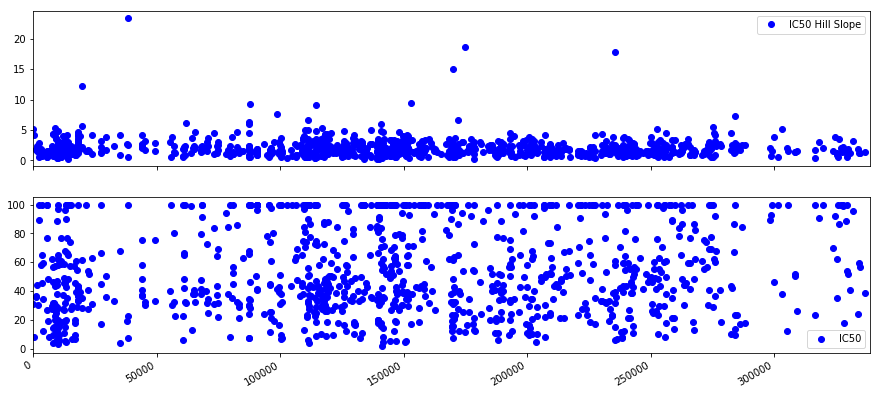

In [9]:
assays.plot(y=["IC50 Hill Slope", "IC50"],style="bo", subplots=True, figsize=(15,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026339A2A668>,
      dtype=object)

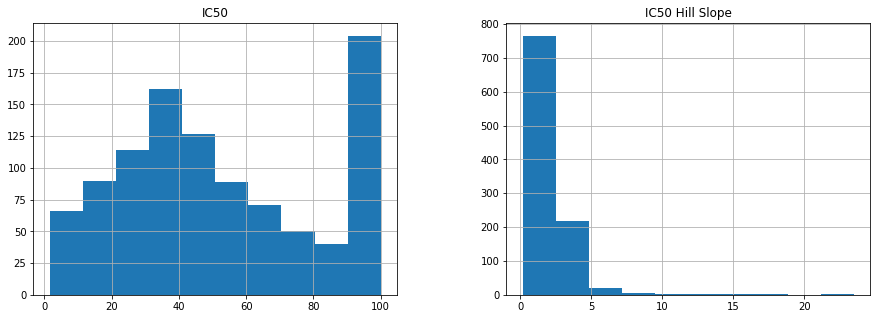

In [10]:
assays.hist(["IC50","IC50 Hill Slope"], figsize=(15,5))

In [11]:
assays[(assays["IC50"] >= 100)].count()

PUBCHEM_SID                            168
SMILES                                 168
PUBCHEM_ACTIVITY_OUTCOME               168
IC50 Modifier                          168
IC50                                   168
IC50 Std Dev                           168
IC50 Hill Slope                        168
IC50 NormChi2                          168
% Inhibition @ 100 uM                  168
% Inhibition @ 50 uM                   167
% Inhibition @ 25 uM                   167
% Inhibition @ 12.5 uM                 168
% Inhibition @ 6.25 uM                 168
% Inhibition @ 3.13 uM                 167
% Inhibition @ 1.56 uM                 168
% Inhibition @ 0.78 uM                 168
% Inhibition @ 0.39 uM                 168
% Inhibition @ 0.19 uM                 168
Primary Outcome                        168
Primary Screen % Inhibition @ 25 uM    168
Verification                           168
dtype: int64

In [12]:
assays[(assays["IC50 Hill Slope"] > 2.0)].count()

PUBCHEM_SID                            386
SMILES                                 386
PUBCHEM_ACTIVITY_OUTCOME               386
IC50 Modifier                           15
IC50                                   386
IC50 Std Dev                           386
IC50 Hill Slope                        386
IC50 NormChi2                          386
% Inhibition @ 100 uM                  384
% Inhibition @ 50 uM                   384
% Inhibition @ 25 uM                   385
% Inhibition @ 12.5 uM                 386
% Inhibition @ 6.25 uM                 386
% Inhibition @ 3.13 uM                 386
% Inhibition @ 1.56 uM                 386
% Inhibition @ 0.78 uM                 386
% Inhibition @ 0.39 uM                 386
% Inhibition @ 0.19 uM                 385
Primary Outcome                        386
Primary Screen % Inhibition @ 25 uM    386
Verification                           386
dtype: int64

In [13]:
assays[((assays["IC50"] < 100) & (assays["IC50 Hill Slope"] <=6))].count()

PUBCHEM_SID                            831
SMILES                                 831
PUBCHEM_ACTIVITY_OUTCOME               831
IC50 Modifier                            0
IC50                                   831
IC50 Std Dev                           831
IC50 Hill Slope                        831
IC50 NormChi2                          831
% Inhibition @ 100 uM                  818
% Inhibition @ 50 uM                   825
% Inhibition @ 25 uM                   829
% Inhibition @ 12.5 uM                 831
% Inhibition @ 6.25 uM                 831
% Inhibition @ 3.13 uM                 830
% Inhibition @ 1.56 uM                 830
% Inhibition @ 0.78 uM                 831
% Inhibition @ 0.39 uM                 831
% Inhibition @ 0.19 uM                 830
Primary Outcome                        831
Primary Screen % Inhibition @ 25 uM    831
Verification                           831
dtype: int64

### Primary Screen
From the primary screen, the criteria to define active compounds is % inhibition > 28.49 (the mean inhibition of the compound population plus three standard deviations), totaling **3,281 *active* compounds**. Those were used in the next "*confirmatory*" screens, which used different concentrations.

In [14]:
assays[(assays["Primary Outcome"] == "Active")].count()

PUBCHEM_SID                            3281
SMILES                                 3281
PUBCHEM_ACTIVITY_OUTCOME               3281
IC50 Modifier                           168
IC50                                   1012
IC50 Std Dev                           1012
IC50 Hill Slope                        1012
IC50 NormChi2                          1012
% Inhibition @ 100 uM                  1714
% Inhibition @ 50 uM                   1733
% Inhibition @ 25 uM                   1735
% Inhibition @ 12.5 uM                 1743
% Inhibition @ 6.25 uM                 1748
% Inhibition @ 3.13 uM                 1746
% Inhibition @ 1.56 uM                 1747
% Inhibition @ 0.78 uM                 1748
% Inhibition @ 0.39 uM                 1748
% Inhibition @ 0.19 uM                 1747
Primary Outcome                        3281
Primary Screen % Inhibition @ 25 uM    3281
Verification                           3281
dtype: int64

In [15]:
assays["Primary Outcome"].value_counts()

Inactive    335572
Active        3281
Name: Primary Outcome, dtype: int64

In [16]:
assays[(assays["Primary Screen % Inhibition @ 25 uM"] > 28.49)].count()

PUBCHEM_SID                            3281
SMILES                                 3281
PUBCHEM_ACTIVITY_OUTCOME               3281
IC50 Modifier                           168
IC50                                   1012
IC50 Std Dev                           1012
IC50 Hill Slope                        1012
IC50 NormChi2                          1012
% Inhibition @ 100 uM                  1714
% Inhibition @ 50 uM                   1733
% Inhibition @ 25 uM                   1735
% Inhibition @ 12.5 uM                 1743
% Inhibition @ 6.25 uM                 1748
% Inhibition @ 3.13 uM                 1746
% Inhibition @ 1.56 uM                 1747
% Inhibition @ 0.78 uM                 1748
% Inhibition @ 0.39 uM                 1748
% Inhibition @ 0.19 uM                 1747
Primary Outcome                        3281
Primary Screen % Inhibition @ 25 uM    3281
Verification                           3281
dtype: int64

In [17]:
assays[(assays["Primary Screen % Inhibition @ 25 uM"] == 28.49)]

,PUBCHEM_SID,SMILES,PUBCHEM_ACTIVITY_OUTCOME,IC50 Modifier,IC50,IC50 Std Dev,IC50 Hill Slope,IC50 NormChi2,% Inhibition @ 100 uM,% Inhibition @ 50 uM,...,% Inhibition @ 12.5 uM,% Inhibition @ 6.25 uM,% Inhibition @ 3.13 uM,% Inhibition @ 1.56 uM,% Inhibition @ 0.78 uM,% Inhibition @ 0.39 uM,% Inhibition @ 0.19 uM,Primary Outcome,Primary Screen % Inhibition @ 25 uM,Verification
253427,17401238,CC1=C(C(=C(S1)NC(=O)C2CCCCC2C(=O)O)C(=O)N)C3=CC=C(C=C3)C(C)C,Active,NaN,62.68,5.74,1.94,5.96,73.85,36.24,...,6.31,9.67,8.45,4.99,0.0,8.79,4.8,Inactive,28.49,verified
338054,843097,CCC(C)(C)N1C(=NN=N1)CN(CC2=CC=CO2)CC3=CC4=CC5=C(C=C4NC3=O)OCO5,Inactive,NaN,NaN,NaN,NaN,NaN,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.0,Inactive,28.49,verified


After the "Primary Screen" compounds were tagged with "Primary Outcome" as *Active* or *Inactive*, accordiing to the following criterion:
- Inhibition @ 25 uM >  28.49% == Active
- Inhibition @ 25 uM <= 28.49% == Inactive

Only 2 compounds fall into the Inhibition == 28.49%, and were tagged with "Primary Outcome == Inactive". However, when deciding which coumpounds to use in the next steps, both were included together with all *Actives*. Inclusive, it is worth mentioning that one of them (PUBCHEM_SID==17401238) later turned out to be *Active* in the confirmatory assays.

We want to separate the data set in the same groups as the original, so we will include those two in the *Active* group here.

In [18]:
primary_active   = assays[(assays["Primary Screen % Inhibition @ 25 uM"] >= 28.49)]
primary_inactive = assays[(assays["Primary Screen % Inhibition @ 25 uM"] <  28.49)]

In [19]:
primary_active["Primary Outcome"].unique(), primary_inactive["Primary Outcome"].unique()

(array(['Active', 'Inactive'], dtype=object),
 array(['Inactive'], dtype=object))

In [20]:
primary_active.shape, primary_inactive.shape

((3283, 21), (335570, 21))

Only the 3,281 compounds deemed *"active"* in the primary screen, plus the 2 *inactive* with I==28.49%, were used in the subsequent steps, totaling **3,283** compounds.

### Confirmatory Assay
From the 3,281 compounds deemed *active* (+ 2 borderline *inactive*) in the primary screen:
- Compounds exhibiting autofluorescent characteristics were excluded.
- Available compounds from the remaining list were screened in the confirmatory assay. 
- Compounds that showed activity in the primary screen, but were not available for further study are labeled as inconclusive.
- **Compound activity is defined as 30% or greater inhibition at _<u>any</u>_ tested concentration.**
- IC50 values were calculated for these compounds

In [21]:
confirmatory_assays = ["% Inhibition @ 100 uM" ,
                       "% Inhibition @ 50 uM"  ,
                       "% Inhibition @ 25 uM"  ,
                       "% Inhibition @ 12.5 uM",
                       "% Inhibition @ 6.25 uM",
                       "% Inhibition @ 3.13 uM",
                       "% Inhibition @ 1.56 uM",
                       "% Inhibition @ 0.78 uM",
                       "% Inhibition @ 0.39 uM",
                       "% Inhibition @ 0.19 uM"]

confirmatory = primary_active[confirmatory_assays]
confirmatory.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3283 entries, 5 to 338820
Data columns (total 10 columns):
% Inhibition @ 100 uM     1716 non-null float64
% Inhibition @ 50 uM      1735 non-null float64
% Inhibition @ 25 uM      1737 non-null float64
% Inhibition @ 12.5 uM    1745 non-null float64
% Inhibition @ 6.25 uM    1750 non-null float64
% Inhibition @ 3.13 uM    1748 non-null float64
% Inhibition @ 1.56 uM    1749 non-null float64
% Inhibition @ 0.78 uM    1750 non-null float64
% Inhibition @ 0.39 uM    1750 non-null float64
% Inhibition @ 0.19 uM    1749 non-null float64
dtypes: float64(10)
memory usage: 282.1 KB


In [22]:
# How many compounds were tested in the confirmatory assays at at least one concentration?
confirmatory.notna().any(axis=1).sum()

1750

In [23]:
# How many compounds were tested in the confirmatory assays for *all* concentrations?
confirmatory.notna().all(axis=1).sum()

1692

That means that 58 molecules are missing some value. Since we will recalculate the IC50s with NCGC CurveFit, those will not be a problem.

In [24]:
# confirmatory_tested will hold all the compounds tested in the confirmatory screen
confirmatory_tested = confirmatory.notna().any(axis=1)

# Confirmatory_full will hold all the 1,692 compounds to which all concentrations wre tested
confirmatory_full   = confirmatory.notna().all(axis=1) 

# Confirmatory_miss will hold all 58 compounds for which come data is missing
confirmatory_miss   = (confirmatory_tested & ~confirmatory_full)

# Inconclusive
confirmatory_inconc = confirmatory.isna().all(axis=1)

confirmatory_tested = primary_active[confirmatory_tested]
confirmatory_full   = primary_active[confirmatory_full]
confirmatory_miss   = primary_active[confirmatory_miss]
confirmatory_inconc = primary_active[confirmatory_inconc]

In [25]:
print("Confirmatory_tested = ", confirmatory_tested.shape)
print("Confirmatory_full   = ", confirmatory_full.shape)
print("Confirmatory_miss   = ", confirmatory_miss.shape)
print("Inconclusive        = ", confirmatory_inconc.shape)

Confirmatory_tested =  (1750, 21)
Confirmatory_full   =  (1692, 21)
Confirmatory_miss   =  (58, 21)
Inconclusive        =  (1533, 21)


In [26]:
confirmatory_tested["PUBCHEM_ACTIVITY_OUTCOME"].value_counts()

Active      1013
Inactive     737
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

In [27]:
confirmatory_full["PUBCHEM_ACTIVITY_OUTCOME"].value_counts()

Active      994
Inactive    698
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

In [28]:
confirmatory_miss["PUBCHEM_ACTIVITY_OUTCOME"].value_counts()

Inactive    39
Active      19
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

In [29]:
confirmatory_inconc["PUBCHEM_ACTIVITY_OUTCOME"].value_counts()

Inconclusive    1533
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

So, the compounds that are missing some values could still be tested, and were active in 33% of the cases. 
For the ones that were tested with all concentrations, 59% were active.

In [30]:
confirmatory.ge(30).any('columns').sum()

1013

So, there are 1,013 entries that showed inhibition > 30% in at least one concentration, and those were used to calculate the IC50s. However, 1,750 compounds were tested. In the experiment, the authors were only interested in the active ligands. However, for modeling, it is important to have the inactive as well. Furthermore, when cleaning the data, we will loose data. So, it is important to use as much data as possible.

### Recalculating the IC50s

To have as much data as possible, lets recalculate the IC50s for all the molecules for which experiment data is available. We will use the software from the National Center for Advancing Translational Sciences (NCATS) Genome Center (NCGC), the NGCG [Curve Fit](https://tripod.nih.gov/curvefit/).

First, we need to generate the data in the correct format for the program to use. For each compound in the list, the format is:

```
"conc" <tab> <tab> <tab-separated list of concentrations in molar units >
<<molID>> <tab> <<SMILES>> <tab> <tab-separated list of Responses in %>
```

In [31]:
with open('./data/conc_x_activity.txt', "w") as output:
    for compound, row in confirmatory_tested.iterrows():
        pubchem_sid = str(row["PUBCHEM_SID"])
        smiles = str(row["SMILES"])
        line1 = "conc \t"
        
        # List of Concentrations
        for column in confirmatory.columns:
            if ~np.isnan(row[column]):
                conc = f"{float(column[15:-2])*1e-6:5.4}" # Conc. in Molar
                line1 = line1 + "\t" + conc
        line1 = line1 + "\n"
        line2 = pubchem_sid + "\t" + smiles
        
        # Values of the results
        for value in row[confirmatory.columns].values:
            if ~np.isnan(value):
                line2 = line2 + "\t" + str(value)
        line2 = line2 + "\n"
        output.write(line1)
        output.write(line2)

(After this, run the NCGC curvefit program on the data generated, and return here to continue the analysis.)

In [32]:
ncgc_results = pd.read_csv("./data/ncgc_results.txt", sep="\t",
                           usecols=["CMPD ID", "Smiles", "Curve Class", "Log EC50", "EC50", "R2"])
ncgc_results.rename(columns={"CMPD ID":"PUBCHEM_SID",
                             "Smiles":"SMILES",
                             "Log EC50": "Log IC50", 
                             "EC50": "IC50"}, inplace=True)

In [33]:
ncgc_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 6 columns):
PUBCHEM_SID    1750 non-null int64
Curve Class    1750 non-null float64
Log IC50       832 non-null float64
IC50           832 non-null float64
R2             832 non-null float64
SMILES         1750 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 82.1+ KB


In [34]:
ncgc_results.head()

,PUBCHEM_SID,Curve Class,Log IC50,IC50,R2,SMILES
0,46501256,1.1,-4.95,11.220185,0.997443,COC1=CC(=O)C(=C(C1=O)CCCCCCC/C=C/CCCCCCCC2=C(C(=O)C=C(C2=O)OC)O)O
1,26671489,1.1,-5.65,2.238721,0.988917,C1=CC2=C(C=C1[O-])OC3=CC(=O)C=CC3=[N+]2[O-].[Na+]
2,50086104,1.1,-5.50,3.162278,0.855065,CC1=CC=C(O1)C(=O)C2=C(C(=O)N(C2C3=CC(=CC=C3)OCC=C)C4=NC=CS4)O
3,99356103,1.1,-5.50,3.162278,0.995536,CC1=NC2=C(C=C1)C(=O)C(=C(C2=O)Br)OC
4,92764075,1.1,-5.50,3.162278,0.992365,COC1=C(C(=O)C2=C(C1=O)C=CC=N2)Br


In [35]:
ncgc_results['Curve Class'].unique()

array([1.1, 1.2, 2.1, 2.2, 4. ])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002633A6BA128>,
      dtype=object)

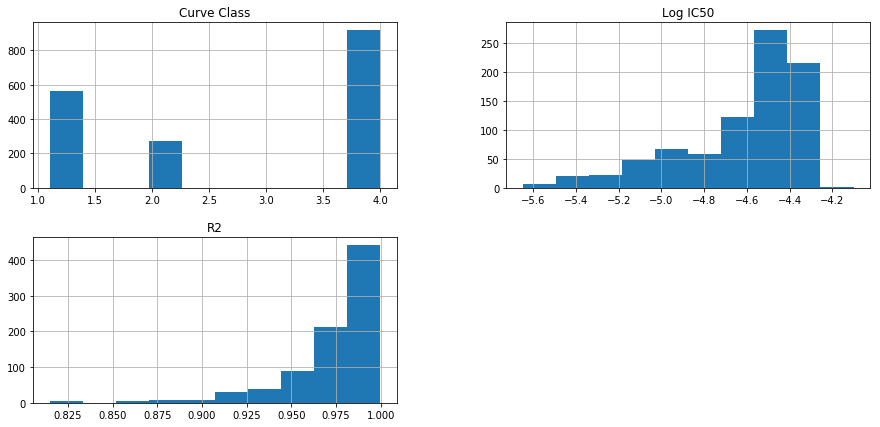

In [36]:
ncgc_results.hist(["Log IC50","Curve Class", "R2"], figsize=(15,7))

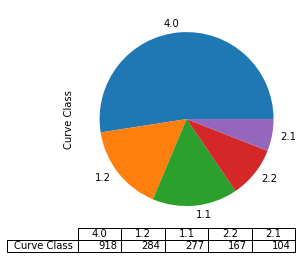

In [37]:
ncgc_results["Curve Class"].value_counts().plot(kind='pie', table=True)

So, there are 832 compounds with Curve Class = 1.1 - 2.2. Compounds with curve class == 4 are just considered inactive, and the IC50 is not even calculated. This leaves us with a database of:

- 832 "Active" compounds
- 918 "Inactive" compounds.

If needed, more "Inactive" compounds can be obtained from the "Inactives" in the primary screening. From now on, we will be working only with the "Active" compounds. The "Inactives" will be dropped because they showed activity in the primary assay, but this could not be reproduced, indicating possible artifacts.

The Curve Class classification is described [here](https://support.collaborativedrug.com/hc/en-us/articles/214359343-Activity-and-Curve-Validation#curve_classification).

In [38]:
ncgc_active = ncgc_results[(ncgc_results["Curve Class"] < 3.0)].copy()
ncgc_active.head()

,PUBCHEM_SID,Curve Class,Log IC50,IC50,R2,SMILES
0,46501256,1.1,-4.95,11.220185,0.997443,COC1=CC(=O)C(=C(C1=O)CCCCCCC/C=C/CCCCCCCC2=C(C(=O)C=C(C2=O)OC)O)O
1,26671489,1.1,-5.65,2.238721,0.988917,C1=CC2=C(C=C1[O-])OC3=CC(=O)C=CC3=[N+]2[O-].[Na+]
2,50086104,1.1,-5.50,3.162278,0.855065,CC1=CC=C(O1)C(=O)C2=C(C(=O)N(C2C3=CC(=CC=C3)OCC=C)C4=NC=CS4)O
3,99356103,1.1,-5.50,3.162278,0.995536,CC1=NC2=C(C=C1)C(=O)C(=C(C2=O)Br)OC
4,92764075,1.1,-5.50,3.162278,0.992365,COC1=C(C(=O)C2=C(C1=O)C=CC=N2)Br


### Standardize the Dataset

Now we need to standardize the dataset, which means:
- Standardize SMILES
- Remove salts
- Remove metals
- Remove duplicates

And this can be done with the [RDkit](http://www.rdkit.org/) and [MolVS](https://molvs.readthedocs.io/en/latest/) modules.

Here, lets work only on the results with curve class <= 2.2. The other compounds (curve class = 4) are inactive, and must have had some interference in the assay.

#### Functions

In [39]:
std = molvs.Standardizer()
taut = molvs.tautomer.TautomerCanonicalizer()
remover = Chem.SaltRemover.SaltRemover()
unchg = molvs.charge.Uncharger()
#unmix = molvs.fragment.FragmentRemover(leave_last=True)
unmix = molvs.fragment.LargestFragmentChooser(prefer_organic=True)

In [40]:
# Determine if the molecule has invalid atoms
valid_atoms=['C','N','O','H','S','P','As','Se','F','Cl','Br','I']
def only_valid_atoms(mol):
    for atom in mol.GetAtoms():
        symb = atom.GetSymbol()
        if symb not in valid_atoms: return False
    return True

In [41]:
# Drops DataFrame rows with invalid atoms
def drop_invalid_mols(frame):
    frame['valid'] = frame['mol'].progress_apply(only_valid_atoms)
    return frame[(frame['valid'])].copy().drop(['valid'],axis=1)

In [42]:
# Standardize a molecule
def standardize_molecule(mol):
    """ 
    Completely standardizes a molecule to be used in this pipeline. The full process includes:
    1. Standardize using MolVS standardizer
    2. Remove salts
    3. Remove mixture fragments (keep the largest organic fragment)
    4. Remove charges (adding / removing Hs)
    5. Canonicalize tautomer: Returns just one 'canonical' tautomer.
    
    INPUT : 'mol': a RDkit ```mol``` object
    OUTPUT: a new RDKit ```mol``` object that has been standaridized.
    """
    this_mol = std.standardize(mol)       # Standardize the mol
    this_mol = remover.StripMol(this_mol, dontRemoveEverything=True)      # Remove salts
    this_mol = unmix.choose(this_mol)          # Remove fragments / mixtures
    this_mol = unchg.uncharge(this_mol)        # Remove charges
    this_mol = taut.canonicalize(this_mol)     # Canonicalize the tautomers
    return this_mol
    

In [47]:
def prepare_data_pipeline(df):
    """ 
    Receives a Pandas Dataframe containing molecules, and processes the 
    whole pipeline in the dataframe.
    
    The DataFrame *must* have a column with the molecular SMILES, and this column
    *must* be named "SMILES".
    
    The pipeline consists in:
    
    1. Standadize the molecules applying `standardize_molecule` to each molecule.
        1.1. Standardize format
        1.2. Removes salts
        1.3. Removes fragments / mixtures
        1.4. Removes charges bu adding / removing H
        1.5. Canonicalize tautomers
    2. Generate InCHi Keys
    3. Remove molecules with invalid atoms
    4. Remove duplicates based on InChi keys
    5. Reset DataFrame index
    
    Returns:
        The new processed DataFrame, with no duplicates, and the extra columns:
            - mol
            - InChi Key
    """

    assert(isinstance(df, pd.DataFrame)), "This function must receive a Pandas DataFrame as argument."
    assert("SMILES" in df.columns), "The DataFrame must have a SMILES column."
    
    _start = time.time()
    # Adds 'mol' column
    Chem.PandasTools.AddMoleculeColumnToFrame(df,smilesCol='SMILES',molCol='mol')

    # Standardize
    tqdm.pandas(desc="Standardizing:")
    df['mol'] = df['mol'].progress_apply(standardize_molecule)

    # Create InChi Keys
    tqdm.pandas(desc="Generating InChi Keys:")
    df['InChi Key'] = df['mol'].progress_apply(Chem.MolToInchiKey)

    # Remove molecules with invalid atoms
    tqdm.pandas(desc="Removing molecules with invalid atoms...")
    df = drop_invalid_mols(df)

    # Remove duplicates
    print("Looking for duplicates...")
    n_duplicates = df.shape[0] - len(df['InChi Key'].unique())
    if n_duplicates > 1:
        print(f"{n_duplicates} duplicates found. Removing...")
        df.drop_duplicates(subset=['InChi Key'], keep='first', inplace=True)
    print("Done")
    
    # Reset DataFrame Indexes
    df.reset_index(drop=True, inplace=True)
    
    print(f"Total time: {(time.time() - _start):0.3} seconds")
    # Done!
    return df

#### Actives

In [44]:
ncgc_active = ncgc_results[(ncgc_results["Curve Class"] < 3.0)].copy()

In [45]:
ncgc_active.head()

,PUBCHEM_SID,Curve Class,Log IC50,IC50,R2,SMILES
0,46501256,1.1,-4.95,11.220185,0.997443,COC1=CC(=O)C(=C(C1=O)CCCCCCC/C=C/CCCCCCCC2=C(C(=O)C=C(C2=O)OC)O)O
1,26671489,1.1,-5.65,2.238721,0.988917,C1=CC2=C(C=C1[O-])OC3=CC(=O)C=CC3=[N+]2[O-].[Na+]
2,50086104,1.1,-5.50,3.162278,0.855065,CC1=CC=C(O1)C(=O)C2=C(C(=O)N(C2C3=CC(=CC=C3)OCC=C)C4=NC=CS4)O
3,99356103,1.1,-5.50,3.162278,0.995536,CC1=NC2=C(C=C1)C(=O)C(=C(C2=O)Br)OC
4,92764075,1.1,-5.50,3.162278,0.992365,COC1=C(C(=O)C2=C(C1=O)C=CC=N2)Br


In [48]:
ncgc_active = prepare_data_pipeline(ncgc_active)


Looking for duplicates...
3 duplicates found. Removing...
Done
Total time: 82.2 seconds


In [49]:
ncgc_active.describe()

,PUBCHEM_SID,Curve Class,Log IC50,IC50,R2
count,8.290000e+02,829.000000,829.000000,829.000000,829.000000
mean,4.170085e+07,1.477443,-4.624427,27.828946,0.974062
std,2.642937e+07,0.475725,0.278188,12.781898,0.026871
min,8.448520e+05,1.100000,-5.650000,2.238721,0.814713
25%,2.478228e+07,1.100000,-4.800000,15.848932,0.966273
50%,2.672420e+07,1.200000,-4.550000,28.183829,0.982946
75%,4.972512e+07,2.100000,-4.400000,39.810717,0.991663
max,1.031636e+08,2.200000,-4.100000,79.432823,0.999892


,PUBCHEM_SID,Curve Class,Log IC50,IC50,R2,SMILES,mol,InChi Key
0,46501256,1.1,-4.95,11.220185,0.997443,COC1=CC(=O)C(=C(C1=O)CCCCCCC/C=C/CCCCCCCC2=C(C(=O)C=C(C2=O)OC)O)O,,DWNCLZCMVGETDL-IIPDRVBESA-N
1,26671489,1.1,-5.65,2.238721,0.988917,C1=CC2=C(C=C1[O-])OC3=CC(=O)C=CC3=[N+]2[O-].[Na+],,PLXBWHJQWKZRKG-UHFFFAOYSA-N
2,50086104,1.1,-5.50,3.162278,0.855065,CC1=CC=C(O1)C(=O)C2=C(C(=O)N(C2C3=CC(=CC=C3)OCC=C)C4=NC=CS4)O,,FZZCCCMFGOTQEO-UHFFFAOYSA-N
3,99356103,1.1,-5.50,3.162278,0.995536,CC1=NC2=C(C=C1)C(=O)C(=C(C2=O)Br)OC,,XEGBXQGPUKNRNM-UHFFFAOYSA-N
4,92764075,1.1,-5.50,3.162278,0.992365,COC1=C(C(=O)C2=C(C1=O)C=CC=N2)Br,,VFJSDBUJXJBRRA-UHFFFAOYSA-N

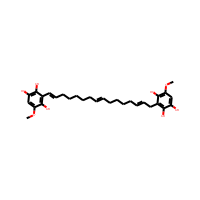
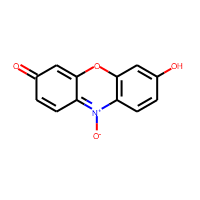
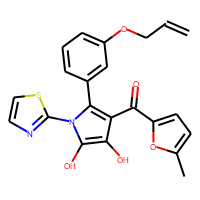
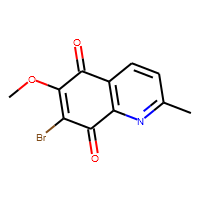
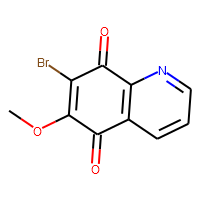

In [53]:
ncgc_active.head()

In [83]:
# Save the data
ncgc_active.to_pickle("./data/active_df.pkl.bz2")

#### Inactives
There are two sources of inactive compounds:
1. Compounds that did not show any activity in the primary screening
1. Compounds that showed curve class == 4 in the ncgc analysis

Here we start with the ```ncgc_inactive``` , and complement the set for 50.000 inactives

In [55]:
ncgc_inactive = ncgc_results[(ncgc_results["Curve Class"] >= 3.0)].copy()

In [63]:
ncgc_inactive.drop(['Log IC50','IC50','R2'],axis=1, inplace=True)

In [64]:
ncgc_inactive.describe()

,PUBCHEM_SID,Curve Class
count,9.180000e+02,918.0
mean,3.048988e+07,4.0
std,2.233077e+07,0.0
min,8.429790e+05,4.0
25%,1.738711e+07,4.0
50%,2.480780e+07,4.0
75%,4.964675e+07,4.0
max,1.031597e+08,4.0


In [65]:
ncgc_inactive.head()

,PUBCHEM_SID,Curve Class,SMILES
832,26724280,4.0,CC1=C(C(N2C(=O)/C(=C/3\C4=CC=CC=C4N(C3=O)CC(=O)O)/SC2=N1)C5=CC=C(C=C5)OC)C(=O)OCC=C.CC(=O)O
833,24820894,4.0,CC1=C(C=C(C(=C1)C2=CC=C(O2)/C=C\3/C(=C(C(=O)NC3=O)C#N)C)[N+](=O)[O-])C
834,49724993,4.0,CC1=C(C=CC(=C1)[N+](=O)[O-])N2C(=O)C3=C(C2=O)C=C(C=C3)C(=O)NC4=CC=CC=C4C(=O)O
835,14728116,4.0,C1CCC2=C(C1)C(=O)N3C(=C(C(=O)N3)N=NC4=CC(=CC=C4)Cl)N2
836,85271326,4.0,C1=CC=C2C(=C1)/C(=C\3/C(=O)N(C(=S)S3)CCS(=O)(=O)O)/C(=O)N2CC(=O)NC4=CC(=CC=C4)Br


In [66]:
ncgc_inactive = prepare_data_pipeline(ncgc_inactive)


Looking for duplicates...
Done
Total time: 48.9 seconds


,PUBCHEM_SID,Curve Class,SMILES,mol,InChi Key
0,26724280,4.0,CC1=C(C(N2C(=O)/C(=C/3\C4=CC=CC=C4N(C3=O)CC(=O)O)/SC2=N1)C5=CC=C(C=C5)OC)C(=O)OCC=C.CC(=O)O,,GPZXHHVMTRUILW-GYHWCHFESA-N
1,24820894,4.0,CC1=C(C=C(C(=C1)C2=CC=C(O2)/C=C\3/C(=C(C(=O)NC3=O)C#N)C)[N+](=O)[O-])C,,RUQFYHUWWFWCLH-ZSOIEALJSA-N
2,49724993,4.0,CC1=C(C=CC(=C1)[N+](=O)[O-])N2C(=O)C3=C(C2=O)C=C(C=C3)C(=O)NC4=CC=CC=C4C(=O)O,,WESMCYOHVNPZNE-UHFFFAOYSA-N
3,14728116,4.0,C1CCC2=C(C1)C(=O)N3C(=C(C(=O)N3)N=NC4=CC(=CC=C4)Cl)N2,,DBLWKANCOKSSHW-UHFFFAOYSA-N
4,85271326,4.0,C1=CC=C2C(=C1)/C(=C\3/C(=O)N(C(=S)S3)CCS(=O)(=O)O)/C(=O)N2CC(=O)NC4=CC(=CC=C4)Br,,IQWKHNPYLCUEJX-ISLYRVAYSA-N

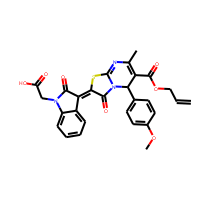
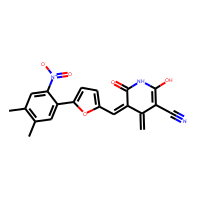
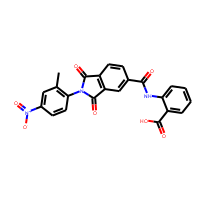
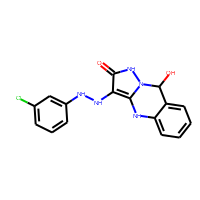
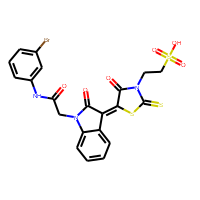

In [67]:
ncgc_inactive.head()

Lets now add the inactives from the original set. Originally, there were 336,307 molecules labeled as inactive. We'll choose only 50,000 of them.

In [68]:
primary_inactive.head()

,PUBCHEM_SID,SMILES,PUBCHEM_ACTIVITY_OUTCOME,IC50 Modifier,IC50,IC50 Std Dev,IC50 Hill Slope,IC50 NormChi2,% Inhibition @ 100 uM,% Inhibition @ 50 uM,% Inhibition @ 25 uM,% Inhibition @ 12.5 uM,% Inhibition @ 6.25 uM,% Inhibition @ 3.13 uM,% Inhibition @ 1.56 uM,% Inhibition @ 0.78 uM,% Inhibition @ 0.39 uM,% Inhibition @ 0.19 uM,Primary Outcome,Primary Screen % Inhibition @ 25 uM,Verification
0,103163618,COC1=C(C=C(C=C1)C2=CSC(=N2)NC(=O)CS(=O)(=O)C3=CC=CC=C3)OC,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,4.03,verified
1,103163617,CC1=C(C=C(C=C1)NC2CCCN(C2)C(=O)C3=CC(=NN3C)C(C)C)C,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,1.10,verified
2,103163612,C1=CC=C(C=C1)CCC2C(=O)N(C(=O)N2)CC(=O)NC3=CC=CC=C3SCC#N,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,8.05,verified
3,103163607,CC1CCCN(C1)C(=O)C2=CC(=CC=C2)S(=O)(=O)NCC3=CC=CC=C3,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,-3.30,verified
4,103163604,CN(C)S(=O)(=O)N1C=C(C2=CC=CC=C21)/C=C(/C(=O)N3CCCCC3)\NC(=O)C4=CC=CC=C4,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,1.65,verified


In [69]:
primary_inactive.index

Int64Index([     0,      1,      2,      3,      4,      6,      7,      8,      9,     10,
            ...
            338843, 338844, 338845, 338846, 338847, 338848, 338849, 338850, 338851, 338852], dtype='int64', length=335570)

In [70]:
sel_primary_inactive = primary_inactive.loc[np.random.choice(primary_inactive.index, size=50000, replace=False)].filter(['PUBCHEM_SID', 'SMILES'], axis=1)

In [71]:
sel_primary_inactive.shape

(50000, 2)

In [72]:
sel_primary_inactive.head()

,PUBCHEM_SID,SMILES
94978,49717421,CC(C)NC(=O)C1=CC(=C(C=C1)N2CC3CC(C2)C4=CC=CC(=O)N4C3)NC(=O)NC5=CC(=CC=C5)OC
33800,57265855,C1CCN(C1)S(=O)(=O)C2=CC=C(C=C2)NC(=O)COC3=C(C=C(C=C3)Br)CO
42177,57257223,C1=CC=C(C=C1)NC2=C(C=C(C=C2)[N+](=O)[O-])C(=O)N
228321,17515507,CCCNC(=O)OCC12CC3CC(C1)CC(C3)C2
48549,56321999,CCCCN1C(=C(C(=O)NC1=O)N(CC)C(=O)C2=CC=C(C=C2)N3CCCC3=O)N


In [73]:
sel_primary_inactive = prepare_data_pipeline(sel_primary_inactive)


Looking for duplicates...
44 duplicates found. Removing...
Done
Total time: 2.45e+03 seconds


In [76]:
sel_primary_inactive.shape

(49951, 4)

In [77]:
ncgc_inactive.columns

Index(['PUBCHEM_SID', 'Curve Class', 'SMILES', 'mol', 'InChi Key'], dtype='object')

In [78]:
sel_primary_inactive.columns

Index(['PUBCHEM_SID', 'SMILES', 'mol', 'InChi Key'], dtype='object')

In [89]:
# Merge (concatenate) 'inactive' dataframes into one
# Get only the first 50.000 elements, drop the excess.
inactive = ncgc_inactive.append(sel_primary_inactive, sort=False)
inactive.drop_duplicates(subset=['InChi Key'], keep='first', inplace=True)
inactive = inactive[:50000].copy()
inactive.reset_index(drop=True, inplace=True)

In [91]:
inactive.index

RangeIndex(start=0, stop=50000, step=1)

,PUBCHEM_SID,Curve Class,SMILES,mol,InChi Key
count,5.000000e+04,918.0,50000,50000,50000
unique,NaN,NaN,50000,50000,50000
top,NaN,NaN,CN(CC(=O)NC1=CC=CC=C1C(F)(F)F)C(=O)CN2C3=CC=CC=C3OC2=O,,CRSIWSIMUCOGCU-UHFFFAOYSA-N
freq,NaN,NaN,1,1,1
mean,3.382297e+07,4.0,NaN,NaN,NaN
std,2.454174e+07,0.0,NaN,NaN,NaN
min,8.421210e+05,4.0,NaN,NaN,NaN
25%,1.738837e+07,4.0,NaN,NaN,NaN
50%,2.482392e+07,4.0,NaN,NaN,NaN
75%,4.972719e+07,4.0,NaN,NaN,NaN

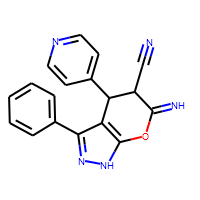

In [92]:
inactive.describe(include='all')

In [93]:
# Save the data
inactive.to_pickle("./data/inactive_df.pkl.bz2")

#### Inconclusive
The ```primary_active``` set has 3,283 compounds, which are all the molecules deemed *active* in the primary screening, plus two "borderline" *inactives*. However, only 1,750 of those were retested in the confirmatory screening. Of the ones not tested, some were removed for being "autofluorescent", and others just didn't have enogh material for retesting. Those were all deemed *inconclusive*. We can separated those in a third set for later.

In [85]:
inconclusive = confirmatory_inconc.filter(["PUBCHEM_SID","SMILES"], axis=1)

In [94]:
inconclusive.shape

(1533, 2)

In [87]:
inconclusive.head()

,PUBCHEM_SID,SMILES
1510,103073730,CC1=C(SC=C1)/C=C\2/C(=O)C3=C(O2)C=C(C=C3)O
1763,103060449,CC(C)OC1=CC=CC=C1/C=C\2/C(=O)N(/C(=C(/C#N)\C(=O)NC3=CC=C(C=C3)C(=O)O)/S2)CCCOC
2164,103050569,C1OC2=C(O1)C=C(C=C2)/C=C\3/C(=O)N(C(=S)S3)CCC(=O)N(CCO)C4=CC=CC=C4
3318,99454010,CCN\1C2=CC=CC=C2C(/C1=C\C=C\C3=[N+](C4=CC=CC=C4C3(C)C)CC)(C)C.[O-]Cl(=O)(=O)=O
3418,99361064,C1=CSC(=C1)C=C(C#N)C2=NC(=CS2)C3=CC=C(C=C3)Cl


In [96]:
inconclusive = prepare_data_pipeline(inconclusive)


Looking for duplicates...
7 duplicates found. Removing...
Done
Total time: 1.52e+02 seconds


In [97]:
inconclusive.shape

(1526, 4)

,PUBCHEM_SID,SMILES,mol,InChi Key
0,103073730,CC1=C(SC=C1)/C=C\2/C(=O)C3=C(O2)C=C(C=C3)O,,NCSQXKWNMARKHD-UHFFFAOYSA-N
1,103060449,CC(C)OC1=CC=CC=C1/C=C\2/C(=O)N(/C(=C(/C#N)\C(=O)NC3=CC=C(C=C3)C(=O)O)/S2)CCCOC,,VCTMLEXFWZBHAH-RJJIQZLVSA-N
2,103050569,C1OC2=C(O1)C=C(C=C2)/C=C\3/C(=O)N(C(=S)S3)CCC(=O)N(CCO)C4=CC=CC=C4,,MJGXNLXLSMFZGM-UYRXBGFRSA-N
3,99454010,CCN\1C2=CC=CC=C2C(/C1=C\C=C\C3=[N+](C4=CC=CC=C4C3(C)C)CC)(C)C.[O-]Cl(=O)(=O)=O,,PUIDNHIQNRMZGS-UHFFFAOYSA-N
4,99361064,C1=CSC(=C1)C=C(C#N)C2=NC(=CS2)C3=CC=C(C=C3)Cl,,DBBZPGMSSKBDQM-UHFFFAOYSA-N

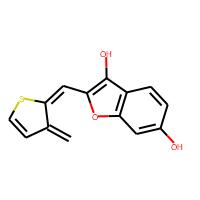
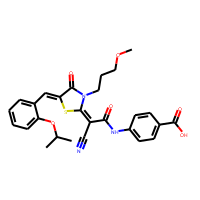
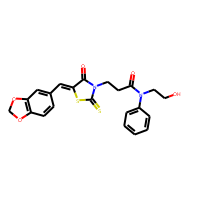
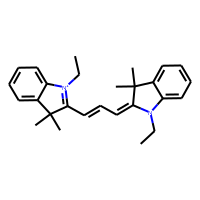
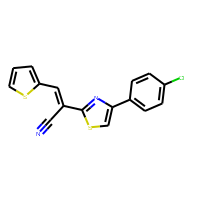

In [98]:
inconclusive.head()

In [99]:
# Save the data
inconclusive.to_pickle("./data/inconclusive_df.pkl.bz2")

### Fingerprints

In [100]:
# Add Fingerprints
def get_rdkfingerprints(mol):
    fp = RDKFingerprint(mol)
    return np.array(list(map(int,fp.ToBitString())))

def get_morganfingerprints(mol):
    fp = GetMorganFingerprintAsBitVect(mol,2)
    return np.array(list(map(int,fp.ToBitString())))

def add_fingerprints(frame):
    tqdm.pandas(desc="Generating RDKit Fingerprints:")
    frame['RDKit Fingerprints'] = frame['mol'].progress_apply(get_rdkfingerprints)
    
    tqdm.pandas(desc="Generating Morgan Fingerprints:")
    frame['Morgan Fingerprints'] = frame['mol'].progress_apply(get_morganfingerprints)
    
    return

#### Actives

In [101]:
add_fingerprints(ncgc_active)

In [102]:
active = ncgc_active.copy()
active['RDKit Fingerprints'].shape

(829,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002639B42B588>,
      dtype=object)

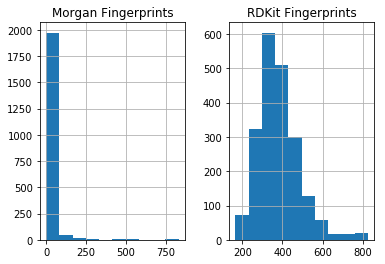

In [103]:
active[['RDKit Fingerprints','Morgan Fingerprints']].apply(sum).hist()

#### Inactives

In [104]:
add_fingerprints(inactive)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002639BDAA400>,
      dtype=object)

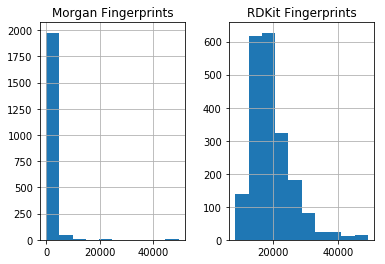

In [105]:
inactive[['RDKit Fingerprints','Morgan Fingerprints']].apply(sum).hist()

#### Inconclusive

In [106]:
add_fingerprints(inconclusive)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002639BD22F98>,
      dtype=object)

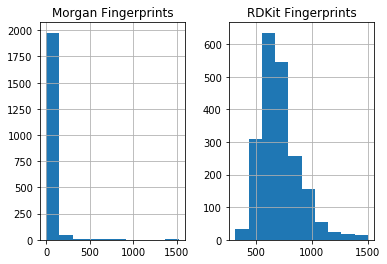

In [107]:
inconclusive[['RDKit Fingerprints','Morgan Fingerprints']].apply(sum).hist()

### Save the data

In [108]:
# This took long... better save the intermediate results
active.to_pickle("./data/active_df_fp.pkl.bz2")
inactive.to_pickle("./data/inactive_df_fp.pkl.bz2")
inconclusive.to_pickle("./data/inconclusive_df_fp.pkl.bz2")